Ce notebook décrit le Projet 9 qui utilise un jeu de données portant sur des données d'achat clients fournies par la starup My Content afin de recommander des contenus pertinents pour ses utilisateurs.

# Projet 9 : Recommandation de Contenu

- L'objectif de ce projet est de mettre en œuvre un outil de recommandation de contenu pour la startup My Content.

- La start-up souhaite tester une solution de recommandation d’articles et de livres à des particuliers.

- Nous allons utiliser des données disponibles en ligne pour développer l'application de recommandation.
https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom
ou



## Introduction sur les systèmes de  recommandation

Un moteur de recommandation efficace est un moteur qui fournit des prévisions précises et personnalisées aux utilisateurs en temps opportun. De tels systèmes ont une importance commerciale croissante. Les algorithmes de filtrage collaboratif nous permettent de donner des prédictions en capturant les points communs entre les utilisateurs.

La valeur ajouté de la startup My Content est donc de :

- recommander des articles et des livres que les utilisateurs aimeraient lire, basés sur les préférences des utilisateurs
leurs notes, ce qu'ils ont lu précedemment.

- la valeur de la startup est dans son algorithme de recommandation.



### Différents type d'approche pour la modélisation d'un système de recommandation

## Les approches basées sur le contenu

Les recommandations basées sur le contenu consistent à déterminer quels éléments du catalogue coïncident le mieux avec les les préférences de l’utilisateur. Cette approche ne requiert pas un grand nombre utilisateurs ou un gros historique d’utilisation du système.

- On recommande des éléments du catalogue similaires à ceux que les utilisateurs ont aimés dans le passé.

- On prend en compte le profil des utilisateurs qui est la clé pour avoir les recommandations les plus pertinentes.

- On fait coïncider les préférences de l’utilisateur et les caractéristiques des livres du catalogue (ou attributs).
Pour un livre par exemple, on peut utiliser le genre, le nom des auteurs, l’éditeur ou toute autre information relative au livre. Ces caractéristiques sont stockées dans un embedding (base de données).

## Les approches basées sur le filtrage collaboratif

Les systèmes basés sur le filtrage collaboratif déterminent des recommandations en calculant la similarité entre les préférences d’un utilisateur et celles d’autres utilisateurs.

Les utilisateurs qui ont aimé un livre donné dans le passé auront tendance à aimer cet élément spécifique, ou un autre très « proche », à nouveau dans l’avenir.

La recommandation est basée sur les goûts précédents de l’utilisateur et sur une mesure de similarité
avec d’autres utilisateurs :

- A partir des préférences d'un utilisateur, on repère un sous-groupe d’utilisateurs dont les préférences sont similaires
à celles de l’utilisateur qui cherche la recommandation ; les préférences pour ce groupe est utilisée pour recommander des livres à l’utilisateur concerné.

    

## Contenu de ce Notebook 

Nous allons exposer trois prinipales parties permettant de préparer une réponse à My Content : 

- 1. Prépartion du Jeu de données


- 2. Etude de différentes modéles utilisés pour un système de recommandation


- 3. Une architecture sur le cloud pour le système de recommandation retenu et de la mise à jour des données

In [88]:
# numpy and pandas for data manipulation
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd 
 # File system manangement
import os
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import StandardScaler

from scipy import sparse
from sklearn.preprocessing import OrdinalEncoder
from implicit.als import AlternatingLeastSquares
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from tqdm import tqdm 


import random
import datetime as dt



from azure.cosmos import CosmosClient, PartitionKey



# matplotlib and seaborn for plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
#import seaborn as sns
import time
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
 



# 1. Présentation générale du jeu de données

Les données fournies est un nensemble de fichiers csv comportant des informations sur l’historique d'achat, les produits achetés avec le nombre de clicks



In [9]:
# files list
print(os.listdir("inputs"))

os.listdir("inputs")

['articles_embeddings.pickle', 'articles_metadata.csv', 'clicks', 'clicks_sample.csv']


['articles_embeddings.pickle',
 'articles_metadata.csv',
 'clicks',
 'clicks_sample.csv']

## 2. Description du jeu de données

In [10]:
data_dir = './inputs'

### Articles dataset

In [11]:
# customers
df_art = pd.read_csv('inputs/articles_metadata.csv')
print('data shape: ', df_art.shape)
print('data info:', df_art.info())
df_art.head()

data shape:  (364047, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB
data info: None


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [12]:
# timestamp to date conversion
df_art['created_at_ts'] = df_art['created_at_ts'].apply(lambda x :  datetime.fromtimestamp(int(x) / 1000))

In [6]:
df_art.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 06:53:39,0,168
1,1,1,2014-07-14 14:45:36,0,189
2,2,1,2014-08-22 02:35:06,0,250
3,3,1,2014-08-19 19:11:53,0,230
4,4,1,2014-08-03 15:06:11,0,162


### Articles embeddings dataset

In [13]:
data_dir = './inputs/'
df_embeddings = pd.read_pickle(Path(data_dir,'articles_embeddings.pickle'))
print(df_embeddings.shape)
df_embeddings

(364047, 250)


array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [14]:
# embedings

#embedding columns number

n_embedings = df_embeddings.shape[1]
df_emb = pd.DataFrame(df_embeddings, columns=["embedding_" + str(i) for i in range(n_embedings)])
df_emb
 

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,-0.124813,...,-0.410549,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,-0.564356,0.676551,-0.446068,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,0.124571,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,-0.329587,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


### Clicks dataset

In [15]:
# customers
df_clicks = pd.read_csv('inputs/clicks_sample.csv')

# timestamp to date conversion
df_clicks['session_start'] = df_clicks['session_start'].apply(lambda x :  datetime.fromtimestamp(int(x) / 1000))
df_clicks['click_timestamp'] = df_clicks['click_timestamp'].apply(lambda x :  datetime.fromtimestamp(int(x) / 1000))

print('data shape: ', df_clicks.shape)
print('data info:', df_clicks.info())
print(df_clicks.shape)
df_clicks.head()

data shape:  (1883, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1883 non-null   int64         
 1   session_id           1883 non-null   int64         
 2   session_start        1883 non-null   datetime64[ns]
 3   session_size         1883 non-null   int64         
 4   click_article_id     1883 non-null   int64         
 5   click_timestamp      1883 non-null   datetime64[ns]
 6   click_environment    1883 non-null   int64         
 7   click_deviceGroup    1883 non-null   int64         
 8   click_os             1883 non-null   int64         
 9   click_country        1883 non-null   int64         
 10  click_region         1883 non-null   int64         
 11  click_referrer_type  1883 non-null   int64         
dtypes: datetime64[ns](2), int64(10)
memory usage: 176.7 KB
data info: 

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 04:37:03,2,157541,2017-10-01 05:00:28.020,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 04:37:03,2,68866,2017-10-01 05:00:58.020,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 04:37:06,2,235840,2017-10-01 05:03:37.951,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 04:37:06,2,96663,2017-10-01 05:04:07.951,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 04:37:15,2,119592,2017-10-01 05:04:50.575,4,1,17,1,24,2


In [16]:
#Check unique values for columns

def unique_counts(df):
    for i in df.columns:
        count=df[i].nunique()
        print(i,' : ',count)

unique_counts(df_clicks)


user_id  :  707
session_id  :  707
session_start  :  619
session_size  :  11
click_article_id  :  323
click_timestamp  :  1883
click_environment  :  3
click_deviceGroup  :  3
click_os  :  6
click_country  :  7
click_region  :  26
click_referrer_type  :  6


# 3. Prétraitement des données

Le but est de ne garder que les données utiles à l'analyse.


In [17]:
# keep only usefull columns

df_clicks = df_clicks[['user_id','session_id','session_start','session_size','click_article_id','click_timestamp']]

In [18]:
df_clicks[df_clicks.duplicated(subset=['user_id'])].sort_values(['user_id','session_id'], ascending=False)
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp
0,0,1506825423271737,2017-10-01 04:37:03,2,157541,2017-10-01 05:00:28.020
1,0,1506825423271737,2017-10-01 04:37:03,2,68866,2017-10-01 05:00:58.020
2,1,1506825426267738,2017-10-01 04:37:06,2,235840,2017-10-01 05:03:37.951
3,1,1506825426267738,2017-10-01 04:37:06,2,96663,2017-10-01 05:04:07.951
4,2,1506825435299739,2017-10-01 04:37:15,2,119592,2017-10-01 05:04:50.575


In [19]:
#sum by article_id

df_ = df_clicks.groupby(by=['user_id','click_article_id'],as_index=False).agg({'click_article_id':pd.Series.nunique})
df_.head(7)

,user_id,click_article_id
0,0,1
1,0,1
2,1,1
3,1,1
4,2,1
5,2,1
6,3,1


In [20]:
# Dataframe articles with embeddings
df_articles = pd.concat([df_art, df_emb], axis = 1)
#articles = df.sample(frac=0.01, random_state=42)
df_articles.head()             


,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,0,0,2017-12-13 06:53:39,0,168,-0.161183,-0.957233,-0.137944,0.050855,0.830055,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,1,2014-07-14 14:45:36,0,189,-0.523216,-0.974058,0.738608,0.155234,0.626294,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,1,2014-08-22 02:35:06,0,250,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,1,2014-08-19 19:11:53,0,230,-0.740843,-0.975749,0.391698,0.641738,-0.268645,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,1,2014-08-03 15:06:11,0,162,-0.279052,-0.972315,0.685374,0.113056,0.238315,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


# 4. Recommandation par filtrage sur le contenu

##  Calcul des recommandations avec la stratégie "dernier click effectué"

#### Génération préférence  user

In [21]:
#strategy=last_click
 
    
def generer_user_preference(user_id, clicks, articles):
    
    #print(clicks[:10])
    user_id = str(user_id)
    
    last_clicked_article_id = clicks[clicks['user_id'].astype(str) == user_id].sort_values("click_timestamp", ascending=False).reset_index(drop=True)
    
    #print(last_clicked_article_id)
    
    last_clicked_article_id=last_clicked_article_id.iloc[0]["click_article_id"]
        
    preference = articles.query("article_id == @last_clicked_article_id")
   

    return preference


In [22]:
# exemple pour user_id = '3'
pref = generer_user_preference('3', df_clicks, df_articles)
pref

,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
236294,236294,375,2017-09-30 17:40:23,0,151,-0.791363,-0.967025,-0.247181,-0.462593,0.238766,...,-0.609091,0.230817,0.090354,-0.457567,-0.026513,-0.433131,0.347777,0.511057,0.47007,0.092472


#### Calcul des articles similaires

In [23]:
def processing(articles, category_id):
    articles_ = articles.drop(["article_id", "similarity"], axis=1, errors="ignore")
    articles_["category_id"] = articles_["category_id"].apply(
        lambda x: category_id if int(x) == category_id else 0
    )
    articles_["created_at_ts"] = articles_["created_at_ts"].apply(
        lambda x: x.value
    )

    return articles_

 
    
# similar articles bases on category   
def generer_similar_articles(preference, articles, n=10):
    
    
    category_id = preference["category_id"].iloc[0]
    
    scaler = StandardScaler()
    articles_std = scaler.fit_transform(processing(articles, category_id))
    preference_std = scaler.transform(processing(preference, category_id))

    articles = articles.copy()
    articles["similarity"] = cosine_similarity(preference_std, articles_std)[0]

    return articles.sort_values("similarity", ascending=False).iloc[:n]




### Calcul des  recommandations sur le contenu pour un user

In [24]:
user_id = "3"

 
#on cherche l'article du dernier click du user
preference = generer_user_preference(user_id, df_clicks, df_articles)


category_id = preference["category_id"].iloc[0]


# on cherche tous les articles dans categorie_id
similar_articles = generer_similar_articles(preference, df_articles)
 
    
similar_articles.head(10)
 

,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,similarity
236294,236294,375,2017-09-30 17:40:23,0,151,-0.791363,-0.967025,-0.247181,-0.462593,0.238766,...,0.230817,0.090354,-0.457567,-0.026513,-0.433131,0.347777,0.511057,0.470070,0.092472,1.000000
237545,237545,375,2017-03-22 07:52:29,0,126,-0.563189,-0.969878,-0.196641,-0.201205,0.129061,...,0.148306,0.541044,-0.748016,-0.503818,-0.039916,0.404650,0.578980,0.575392,0.129085,0.919563
232150,232150,375,2016-04-13 08:09:57,0,147,-0.580283,-0.967843,-0.180721,0.027619,-0.066731,...,-0.217632,0.228312,-0.371993,-0.340796,-0.401506,0.639226,0.479169,0.562390,0.098408,0.904590
234849,234849,375,2017-10-20 14:28:57,0,168,-0.586949,-0.970846,-0.319814,-0.251130,-0.012318,...,0.011486,0.409875,-0.550666,-0.195624,-0.367871,0.639685,0.747471,0.507668,0.047119,0.897577
234158,234158,375,2017-11-07 08:46:03,0,134,-0.871171,-0.967460,-0.077225,-0.487166,0.296935,...,0.223601,0.338224,-0.609809,-0.056713,-0.273362,0.630999,0.701557,0.552207,0.277444,0.896744
236621,236621,375,2017-11-10 20:26:14,0,157,-0.858401,-0.974622,-0.193919,-0.009141,0.223446,...,-0.297383,0.272960,-0.593383,0.092055,-0.248597,-0.053974,0.320248,0.805304,0.375324,0.894111
235993,235993,375,2017-02-14 13:41:20,0,147,-0.804565,-0.970428,-0.039693,-0.443538,0.418391,...,0.329196,0.185714,-0.586166,-0.243007,-0.077854,0.451017,0.350507,0.807062,0.016965,0.893564
236254,236254,375,2017-10-25 00:26:43,0,154,-0.686492,-0.966230,-0.622432,-0.473130,0.014656,...,0.559664,0.527611,-0.864909,-0.065056,-0.157903,0.429181,0.762348,0.754155,0.215084,0.893448
234174,234174,375,2017-07-22 10:41:43,0,130,-0.665146,-0.969871,-0.143662,-0.423366,0.454046,...,0.350558,-0.354461,-0.683520,-0.491762,-0.199236,0.321826,0.183670,0.604821,0.141200,0.892977
234044,234044,375,2017-08-16 12:17:13,0,151,-0.847483,-0.967493,-0.462551,-0.241957,-0.041849,...,-0.133354,0.233804,-0.818884,-0.023278,0.225327,0.171760,0.218871,0.299156,0.249313,0.891456


# 5. Recommandation par collaborative filtering

## 5.1  Modèle svd (singular value decomposition) de la librairie Surprise

### Creation du dataset des ratings 

Afin d'entrainer un système de recommandation avec Surprise, nous devons créer un Object Dataset.
Un objet Surprise Dataset est un ensemble de données qui contient les champs suivants dans cet ordre :
- Les identifiants des utilisateurs
- Les identifiants des articles (dans ce cas, les identifiants de chaque livre)
- La note correspondante (exemple : une échelle de 1 à 5)

### Calcul des ratings à partir des clicks

In [25]:
# générer les ratings à partir des clicks

def generer_ratings_from_clicks(clicks):
    
    user_article_clicks = (clicks.reset_index().groupby(["user_id", "click_article_id"]).agg(
            COUNT_article_clicks=("index", "count"),
        )
    )

    user_clicks = (clicks.reset_index().groupby(["user_id"]).agg(
            COUNT_user_clicks=("index", "count"),
        )
    )

    ratings = user_article_clicks.join(user_clicks, on="user_id")
    
    ratings["rating"] = round((ratings["COUNT_article_clicks"] / ratings["COUNT_user_clicks"])*10,2)

    ratings =  ratings["rating"].reset_index().rename({"click_article_id": "article_id"}, axis=1)
 

    return ratings



In [26]:
df_ratings = generer_ratings_from_clicks(df_clicks)
df_ratings.head(15)

,user_id,article_id,rating
0,0,68866,5.00
1,0,157541,5.00
2,1,96663,5.00
3,1,235840,5.00
4,2,30970,5.00
5,2,119592,5.00
6,3,236065,5.00
7,3,236294,5.00
8,4,44488,5.00
9,4,48915,5.00


In [27]:
# read ratings into a Surprise Dataset

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'article_id', 'rating']], reader)
data

### Utilisation du modèle SVD

SVD est un algorithme de factorisation matricielle populaire qui peut être utilisé pour les systèmes de recommandation.
- Les systèmes de recommandation qui utilisent la factorisation matricielle suivent généralement un modèle dans lequel une matrice de notation R est factorisée en un produit de matrices représentant les facteurs Q (livres) et les utilisateurs P.


- La matrice de notation R a des valeurs manquantes à certains endroits. L'algorithme de factorisation matricielle utilise une procédure telle que la descente de gradient pour minimiser l'erreur lors de la prédiction des notes existantes à l'aide des facteurs matriciels. Ainsi, un algorithme comme SVD construit un système de recommandation en nous permettant de "remplir les valeurs manquantes dans la matrice de notation, en prédisant les notes que chaque utilisateur attribuerait à chaque élément de l'ensemble de données.
 
- Dans le cas de notre système de recommandation de livres, l'algorithme SVD représentera la matrice de notation comme un produit de matrices représentant respectivement les facteurs de livre et les facteurs d'utilisateur.

Remarque : Les explications plus détaillée de cet algorithme se trouvent dans les notes de cours du Stanford CS 246.

#### Training

In [28]:

# using an SVD model

svd = SVD(verbose=True, n_epochs=10)

# we can cross-validate the SVD model using three-fold cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# train the model on the entire dataset using the fit method after converting the dataset for cross-validation
# into a Surprise Train set object using the build_full_trainset method

trainset = data.build_full_trainset()
svd.fit(trainset)



Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1884  1.1493  1.1415  1.1597  0.0205  
MAE (testset)     1.0831  1.0311  1.0383  1.0508  0.0230  
Fit time          0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Proce

#### Prédiction des ratings

In [29]:
# predict the rating a user would assign to a book
# given a user id (uid) and an article id (iid)

svd.predict(uid=10, iid=100)



Prediction(uid=10, iid=100, r_ui=None, est=3.6780464862730637, details={'was_impossible': False})

- Le champ "est" indique la note estimée du livre pour l'utilisateur spécifique.


- Le modèle a prédit que cet utilisateur spécifique attribuerait une note de 3.7 (d'environ de quatre étoiles) au livre correspondant à un IID de 100.


- Le modèle ne recommande pas directement les livres mais nous pouvons utiliser cet utilitaire de prédiction de notation pour identifier les livres qu'un utilisateur apprécierait probablement, ce qui nous permet de justifier de les recommander à un utilisateur.

### Générer des recommandations des livres

Pour génèrer une recommandation de livres pour un utilisateur on parcourt la liste des identifiants des livres en prédisant les notes des utilisateurs pour chaque identifiant de livre jusqu'à ce qu'on trouve un livre avec une note égale ou supérieure au seuil qui le qualifie pour être recommandé à un utilisateur.


In [30]:
df_ratings.head(5)

,user_id,article_id,rating
0,0,68866,5.0
1,0,157541,5.0
2,1,96663,5.0
3,1,235840,5.0
4,2,30970,5.0


In [31]:
print("il ya ",df_ratings['article_id'].duplicated().sum()," articles en doublons")

il ya  1560  articles en doublons


In [32]:
#  generate recommandations for a user


# Predicts a rating (on a scale of 1-5) that a user would assign to a specific article
def predict_rating(user_id, article_id, model):
 
    prediction = model.predict(uid=user_id, iid=article_id)
    prediction_est = round(prediction.est,2)
    return prediction_est


# Generates recommendations
def generate_recommendation(user_id, model, ratings):
    
    
    df = pd.DataFrame(columns=["article_id"])
    df["article_id"] = ratings[ratings["user_id"] != user_id].article_id.unique()
   

    df["prediction"] = df["article_id"].apply(lambda x : predict_rating(user_id, x , model))
        
   

    return df



#### Recommandations pour un user

In [33]:
# # Generates recommendations for user_id = 1000 based on the best predictions
n=5

data_rec = generate_recommendation(1000, svd, df_ratings)

data_top = data_rec.sort_values("prediction", ascending=False).iloc[:n]

data_top

,article_id,prediction
26,108854,4.20
3,235840,4.16
2,96663,4.15
5,119592,4.14
25,145166,4.07


Remarque : Améliorations des recommandation par le modèle (processus itératif et incrémental) :

Après qu'un utilisateur a fait un nouveau click sur un livre, nous pouvons ajouter ces données aux données existantes et recycler le modèle pour produire un système de recommandation encore meilleur.

# 6. Calcul des recommandations avec Azure Function et CosmosDB

## Architecture choisie

Principe de l'architecture :

1.  On sauvegarde les recommandations sur cosmosDB (cloud Azure)
2.  On utilise une azure function (développée avec vscode et publiée sur le cloud Azure) afin d'afficher les recommandations pour un user donné à partir de la base cosmosDB.

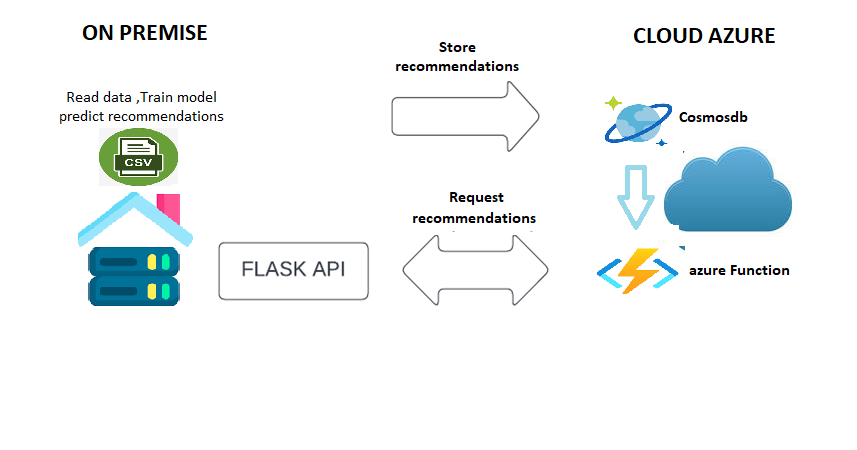

## 6.1 Utilisation de l'Azure portal pour Créer la ressource cosmosDB et Vscode (Visual Studio Code) pour créer et déployer l'Azure fonction sur le cloud

Voici les étapes :
    
    
1. Créez une ressource Azure Cosmos DB sur le portal.

2. Inséser les données de recommandation dans cosmos DB à partir du Notebook

2. Dans vscode : Installez Azure Functions Core Tools et l'extension Azure Cosmos DB pour Visual Studio Code.

3. Créez un projet Azure Functions dans Vscode.

4. Ajoutez un déclencheur Cosmos DB à cette fonction.

5. Écrivez le code pour lire les enregistrements (articles) pour un user donné à partir de la base de données Cosmos DB.

6. Publiez la fonction sur Azure.

7. Testez la fonction pour un user donné en utilisant une API Flask


## 6.1 Sauvegarde des résultats de recommandations sur CosmosDB du cloud Azure

### Preparation des ressources pour CosmosDB database

In [87]:
#creation de cosmosDB account
# ressource and ressource group
# avec Azure CLI 

AZ_COSMOSDB_URI = 'https://cosmos-db-3.documents.azure.com:443/' 
AZ_COSMOSDB_KEY = '8C9whVkoIGPSEAOtj2b0yc2Wp1U9GmeCyqzlKv3DA6vQ7uwdprd8rOD3yNHNMMq3fWkiQxyXmkXyACDbrrDwyQ=='

# database: os.environ.get('COSMOS_DATABASE', 'Books'),
# container: os.environ.get('COSMOS_CONTAINER', 'Items'),
 

### Creation de CosmosDB database

In [6]:
#pip3 install azure-cosmos
## Creer CosmosDB client et database
# Creer les articles pour chaque user dans un Container (les records database)
# le partition key path (‘/id’) est un attribut du container utilisé par CosmosDB pour grouper et partitionner le dataset

client = CosmosClient(AZ_COSMOSDB_URI, AZ_COSMOSDB_KEY)
database = client.create_database_if_not_exists(id="Books")
container = database.create_container_if_not_exists(
    id="Items", #  nom du container
    partition_key=PartitionKey(path="/id"),
)


### Preparation des recommandations Users

In [35]:
user_ids = df_ratings["user_id"].unique().astype("int")

recos = []

for i, user_id in tqdm(enumerate(user_ids)):
    data_rec = generate_recommendation(user_id, svd, df_ratings)
    data_top = data_rec.sort_values("prediction", ascending=False).iloc[:n]
    recos.append(data_top.article_id.values.tolist())



    
user_ids = ratings["user_id"].unique().astype("int")
recos, _ = model.recommend(user_ids, ratings_sparse[user_ids], N=10)

for i, user_id in tqdm(enumerate(user_ids)):
    container.upsert_item(
        body={
            "id": str(user_id),
            "articles": [str(article_id) for article_id in recos[i]],
        }
    )


707it [00:05, 137.70it/s]


In [80]:
data =[]
for i, user_id in tqdm(enumerate(user_ids)):
    articles = [str(article_id) for article_id in recos[i]]
    data.append([user_id,articles])  
    print("user id:", str(user_id),"articles:",articles)

df_articles_users = pd.DataFrame(data, columns = ['user_id','articles'])
df_articles_users.to_csv("articles_users", encoding='utf-8', index=False)

707it [00:00, 59073.53it/s]

user id: 0 articles: ['96663', '119592', '68866', '145166', '108854']
user id: 1 articles: ['108854', '96663', '63821', '202436', '235840']
user id: 2 articles: ['108854', '96663', '119592', '235840', '95742']
user id: 3 articles: ['96663', '235840', '68866', '202436', '119592']
user id: 4 articles: ['235840', '108854', '96663', '237620', '119592']
user id: 5 articles: ['108854', '96663', '271216', '284847', '145166']
user id: 6 articles: ['235840', '119592', '288431', '190703', '96663']
user id: 7 articles: ['235840', '284847', '108854', '96663', '119592']
user id: 8 articles: ['288431', '96663', '145166', '209723', '108854']
user id: 9 articles: ['108854', '209723', '166552', '284847', '96663']
user id: 10 articles: ['96663', '119592', '235840', '108854', '284847']
user id: 11 articles: ['119592', '96663', '235840', '108854', '284847']
user id: 12 articles: ['96663', '108854', '202436', '284847', '145166']
user id: 13 articles: ['235840', '96663', '145166', '68866', '284847']
user id

### Insertion des recommendations dans CosmosDB

In [37]:
## Inserer les recommendations dans CosmosDB
 
for i, user_id in tqdm(enumerate(user_ids)):
    container.upsert_item(
        body={
            "id": str(user_id),
            "articles": [str(article_id) for article_id in recos[i]],
        }
    )

707it [00:14, 47.48it/s]


### Test de lecture des recommandations

In [77]:
def read_items(container):
    print('\nReading all items in a container\n')

    # NOTE: Use MaxItemCount on Options to control how many items come back per trip to the server
    #       Important to handle throttles whenever you are doing operations such as this that might
    #       result in a 429 (throttled request)
    item_list = list(container.read_all_items(max_item_count=10))

    print('Found {0} items'.format(item_list.__len__()))

    for doc in item_list:
        print('Item Id: {0}'.format(doc.get('id')))
        print('Item Id: {0}'.format(doc.get('articles')))


In [78]:
read_items(container)


Reading all items in a container

Found 728 items
Item Id: e9fb3970-2b10-4161-bfae-109c279fc173
Item Id: None
Item Id: aa8eac5f-aa3d-4218-ab04-4fe202eebc03
Item Id: None
Item Id: f2e0b79e-dc15-4c14-9c65-a7506bd34f7b
Item Id: None
Item Id: 9f3718e6-0281-428e-8ef4-c95973f118ca
Item Id: None
Item Id: 2796409a-05e8-4ab3-b156-3b5ea6a6f01c
Item Id: None
Item Id: eec81f30-06e5-4e2f-9532-6c4cc216b2df
Item Id: None
Item Id: 4ba267de-d030-47d7-97a5-9397984145b6
Item Id: None
Item Id: b1d8a96f-45be-4cac-a5da-f6b764828bc1
Item Id: None
Item Id: f0bcba6d-59ad-4078-a1cb-5ebe4f50766c
Item Id: None
Item Id: 86a0b996-3fc3-442c-aa8e-e03b43a9f91e
Item Id: None
Item Id: e0d5bfe8-0552-4301-8c05-84dfa56a8ca2
Item Id: None
Item Id: f1c4d3be-85ff-4846-ba20-b795db42e5f0
Item Id: None
Item Id: bedc0b6a-091c-4957-8889-0e8db2b9b3af
Item Id: None
Item Id: ae79079a-187f-4be6-a529-2456f00cf59d
Item Id: None
Item Id: 488f0b18-6fcd-4b0d-8a8a-35175cc87f2f
Item Id: None
Item Id: 5732dc1a-f855-46d9-9654-20a071f0d019
Ite

## 6.2 Création d'une Azure Fonction

L'azure fonction permet de récupérer les Recommandations à partir de CosmosDB

### Création d'une Azure fonction avec vscode et publication sur le portail Azure

Article utilisé :
https://learn.microsoft.com/en-us/azure/azure-functions/functions-develop-vs-code?tabs=python#run-functions-locally

Les deux éléments de l'Azure fonction à changer dans vscode sont : 

- **function.json** : permettant de décrire le binding http et celui de cosmos DB

- **__init__.py** de l'azure fonction contient le code permettant de lire les enregistrements (articles) pour un user donné à partir de la base de données Cosmos DB.

In [ ]:
# function.json
# avec les bindings http et cosmosDB in

{
  "scriptFile": "__init__.py",
  "bindings": [
    {
        
      #binding http
        
      "authLevel": "anonymous",
      "type": "httpTrigger",
      "direction": "in",
      "name": "req",
      "methods": [
        "get",
        "post"
      ]
    },
    {
      "type": "http",
      "direction": "out",
      "name": "$return"
    },
    {
        
      #binding in cosmosdb
        
      "type": "cosmosDB", 
      "direction": "in",
      "name": "recommendationDOCUMENT",
      "databaseName": "Books",
      "collectionName": "Items",
      "connectionStringSetting": "cosmosdb3_DOCUMENTDB",
      "partitionKey": "id"
    }
  ]
}

In [ ]:
# code de l'azure function (__init__.py)

import logging
import json
import azure.functions as func


def main(req: func.HttpRequest, recommendationDOCUMENT: func.DocumentList) -> func.HttpResponse:

    userId = req.params.get('userId')

    if not recommendationDOCUMENT:
        logging.warning("item not found")
        return func.HttpResponse("item not found",status_code=200)
    else:
        logging.info("item found, Description=%s", len(recommendationDOCUMENT))

        for doc in recommendationDOCUMENT:
            #logging.info('Item Id: {0}'.format(doc.get('id')))
            #logging.info('Item Id: {0}'.format(doc.get('articles')))
            if doc.get('id') == userId:
                art = doc.get('articles')
                break

        result = json.dumps(art)

        return func.HttpResponse(result, mimetype="application/json",status_code=200)

### Test unitaire de l'Azure Function

In [82]:
# test avec Azure Function endpoint
url_azure = "https://azure-func-rec6.azurewebsites.net/api/azure-func6"

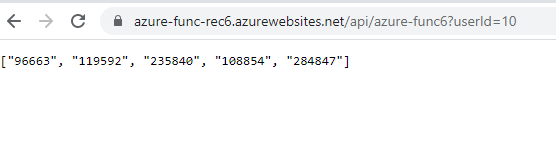

## 6.3. Application Flask

On utilise une Application simple (Flask),  avec le système de recommandation en serverless sur Azure (url_azure) recevra en entrée un identifiant utilisateur et retournera les recommandations d’articles associées (par exemple le top 5).

In [ ]:
# Url Flask en local
url_flask : http://localhost:5000            
# Azure Function endpoint utilisé par l'application Flask
url_azure = "https://azure-func-rec6.azurewebsites.net/api/azure-func6"

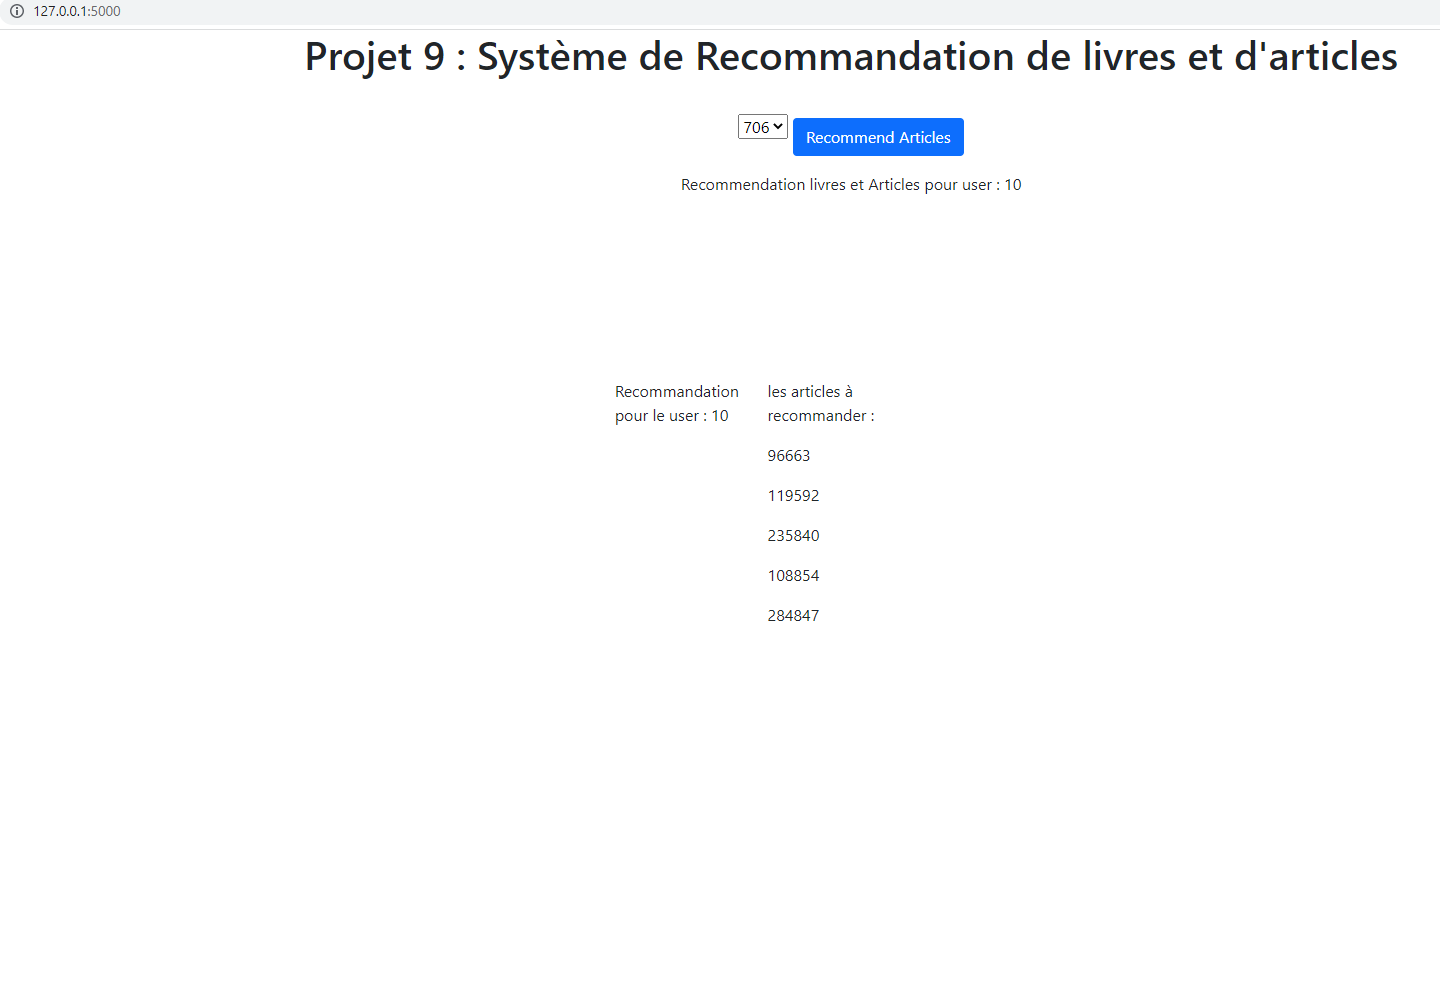

# 7. Architecture Cible (future) 

Dans une architecture future, On utilisera une application mobile qui va se connecter à une base cosmosDB "user-articles" dans le cloud afin de mettre à jours les users et articles objets de clicks. Le calcul des recommandations est délenché par la Fonction Azure dès la mise à jour de ces informations dans la base CosmosDB. Les résultats de recommandation sont mis à jour dans une base cosmos DB "recommandation".

## Obtenir les recommandations après Ajout de nouveaux users ou Articles

Azure Cosmos DB est une base de données distribuée et accessible partout dans le monde ce qui constitue le choix idéal pour un système de recommandation Pour notre Startup. Cosmos DB dispose d'un large éventail de modèles de données et d'API, et elle est facile à mettre à l'échelle.

Pour gérer un système de recommandation à l'aide d'Azure Cosmos DB et d'Azure Functions, ons doit créer deux Azure Functions : La premiere servira à mettre à jour les utilisateurs et les articles de la base de données, tandis que la seconde servira à fournir les recommandations obtenues.


- La première fonction Azure permet d'insérer de nouveaux utilisateurs ou articles et met à jour ceux qui existent.

On doit utiliser un Azure Event Grid pour déclencher la fonction Azure chaque fois qu'un nouvel utilisateur ou article est ajouté à la base de données. Cela garantira que les recommandations sont toujours à jour.

Afin de ne pas solliciter la functions Azure à chaque nouvelle mise à jour de users ou d'articles on peut envisager à tout moment d'utiliser un Azure timer permettant de ne déclecher la fonction azure qu'une seule fois par jour par exemple.

- La deuxième fonction Azure elle, utilise Azure Cosmos DB pour récupérer les données de recommandations afin qu'elles soient affichées sur l'application mobile.  

### Proposition d'une Architecture Cible

L’exemple suivant montre que fonction Azure 1 est invoquée lorsqu’il y a des insertions ou mises à jour dans la base de données CosmosDB alors que la fonction Azure 2 est invoquée par l'application Mobile afin de récupérer les recommandations calculées pour un user donné.

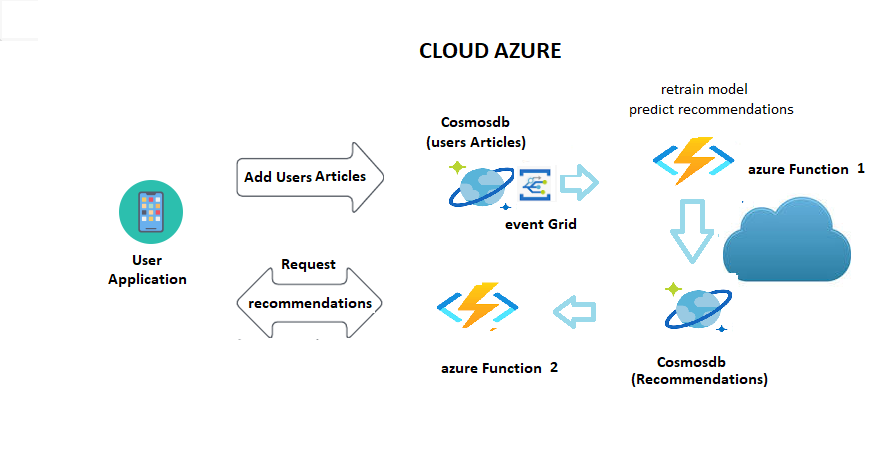

# 8. Sauvegarde sur Github

Ce travail a été sauvegardé sur github (système de gestion de versions) sous le répositorie publique suivant :

https://github.com/rocchdi/recommendation-system-with-azure

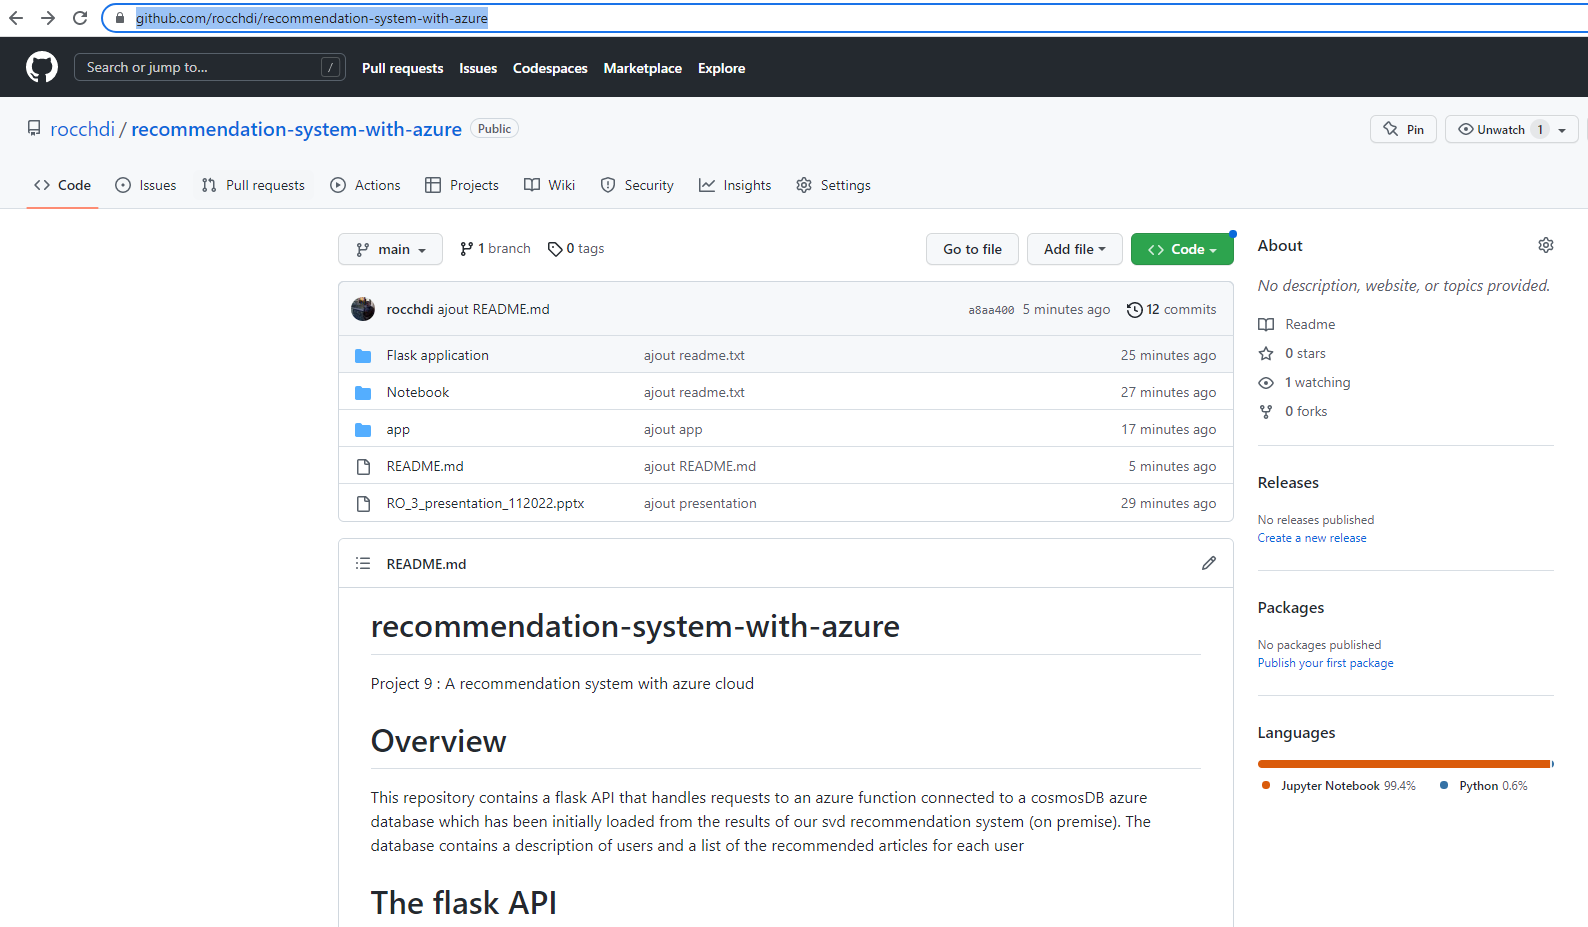